In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Final cleaned data.csv")

for i in df.columns:
    print(i)

Unnamed: 0.1
Unnamed: 0
encounter_id
patient_nbr
race
gender
age
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
tolazamide
insulin
glyburide-metformin
glipizide-metformin
diabetesMed
readmitted
med_count_1
med_change_1
med_count_2
med_change_2
med_count_3
med_change_3
med_count_4
med_change_4
med_count_5
med_change_5
med_count_6
med_change_6
med_change_other
discharge_group
admission_type_cleaned
admission_source_cleaned
diag1_category
max_glu_serum_cleaned


<ipython-input-2-2a6f340c5609>:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Final cleaned data.csv")


In [5]:
df = df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1)
df

KeyError: "['Unnamed: 0.1', 'Unnamed: 0'] not found in axis"

In [6]:
# Check for missing values
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2232
gender                          0
age                             0
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
number_diagnoses                0
A1Cresult                   82506
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metf

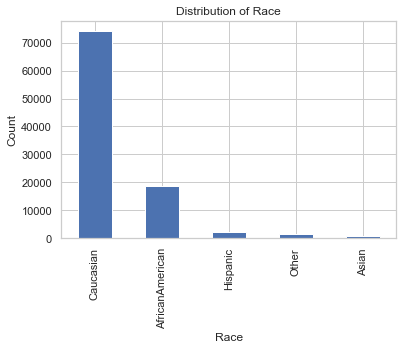

In [305]:
# Check distribution of race 
df["race"].value_counts()

df['race'].value_counts().plot(kind='bar')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Race')
plt.show()

#### Data imputation methods 

1. Race (2273 missing values): KNN Imputation would not really work here. We can also assign the mode (Caucasian) to these values --> Save missing values as an "Unknown" 

2. A1Cresult (82506 "missing" values): Not missing values --> Save values as "Not Taken"
   
3. Diag1_category (21 missing values) --> Save missing values as an "Unknown" 

4. max_glu_serum_cleaned (96420 "missing" values): Not missing values --> Save values as "Not Taken"


In [7]:
# Assign "Unknown" value to missing data in categorical columns 
def assign_unknown(df, cols):
    for col in cols:
        df[col] = df[col].fillna(value="Unknown")

assign_unknown(df, ["race", "diag1_category"])

# Replace NaN values with None in Max_glu_serum_cleaned and A1Cresult
df['max_glu_serum_cleaned'] = df['max_glu_serum_cleaned'].fillna(value="Not Taken")
df['A1Cresult'] = df['A1Cresult'].fillna(value="Not Taken")

In [8]:
# Check for missing values again
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
number_diagnoses            0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
tolazamide                  0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
diabetesMed                 0
readmitted                  0
med_count_1                 0
med_change

In [9]:
## Convert categorical variables that take on numeric form to strings
for col in ['discharge_group', 'admission_type_cleaned', 'admission_source_cleaned', 'diag1_category']:
    df[col] = df[col].astype(str)

In [10]:
## Convert target to binary
mapping = {'>30': 1, '<30': 1, 'NO': 0}
df['readmitted'] = df['readmitted'].replace(mapping)

In [310]:
df.to_csv("Final_cleaned_imputed_binary.csv")

### Explore correlation
- Results: no highly-correlated variables among numeric variables

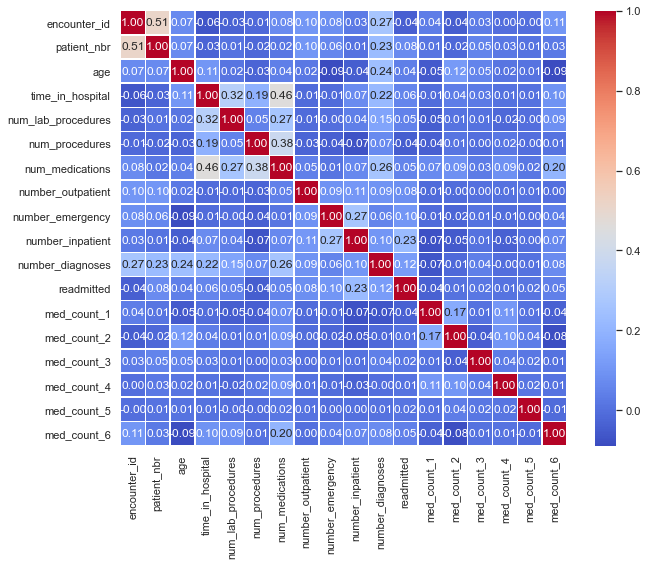

In [11]:
## Numeric variables
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))  # Set the figure size
sns.set(font_scale=1.0)  # Adjust font size
sns.set_style("whitegrid")  # Set style (optional)

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Display the heatmap
plt.show()

<AxesSubplot:>

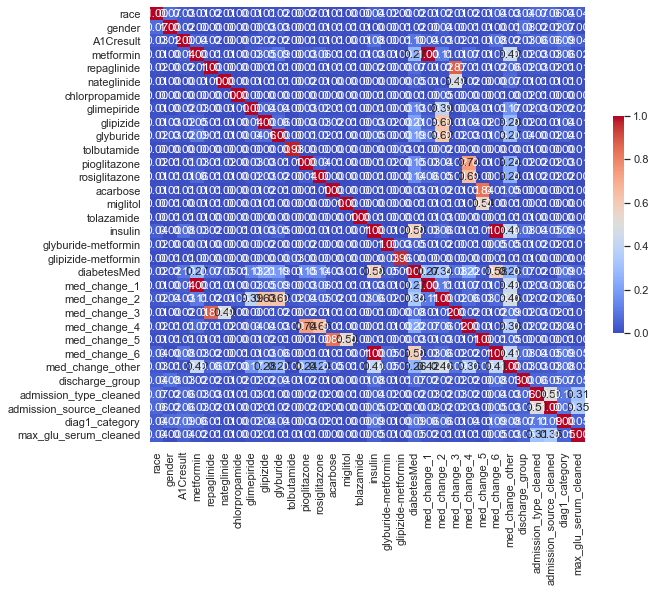

In [286]:
## Categorical variables

from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V for two categorical series, x and y."""
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = len(x)
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

categorical_columns = df.select_dtypes(include=['category', 'object']).columns

# Initialize an empty DataFrame to store the results
corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

# Calculate Cramér's V for each pair of categorical columns
for col1 in categorical_columns:
    for col2 in categorical_columns:
        corr_matrix.at[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .5})

### One-hot encoding

In [287]:
df.columns
## Categorical columns: race, gender, A1Cresult, diabetesMed, med_change_1,2,3,4,5,6,other, 
## discharge_group, admission_type_cleaned, admission_source_cleaned, diag1, max_glu_serum_cleaned
## + all the medications

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin', 'diabetesMed',
       'readmitted', 'med_count_1', 'med_change_1', 'med_count_2',
       'med_change_2', 'med_count_3', 'med_change_3', 'med_count_4',
       'med_change_4', 'med_count_5', 'med_change_5', 'med_count_6',
       'med_change_6', 'med_change_other', 'discharge_group',
       'admission_type_cleaned', 'admission_source_cleaned', 'diag1_category',
       'max_glu_serum_cleaned'],
      dtype='object')

In [288]:
## One-hot encode all categorical variables in X

from sklearn.preprocessing import OneHotEncoder

X = df.drop(columns=['readmitted'])  # Exclude the 'target' column

categorical_columns = ['race', 'gender', 'A1Cresult', 
                       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone','rosiglitazone', 'acarbose', 
                       'miglitol', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                       'diabetesMed', 'med_change_1',
       'med_change_2', 'med_change_3', 'med_change_4', 'med_change_5',
       'med_change_6', 'med_change_other', 'discharge_group', 'admission_type_cleaned', 'admission_source_cleaned', 
        'diag1_category', 'max_glu_serum_cleaned']

encoder = OneHotEncoder(sparse=False, drop='first')  # Use sparse=False to get a dense array
X_encoded = encoder.fit_transform(X[categorical_columns])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names(categorical_columns))

# Drop the original categorical columns from X
X = X.drop(columns=categorical_columns)
X = pd.concat([X, X_encoded_df], axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [289]:
y = df['readmitted']

In [290]:
df2 = pd.concat([X, y], axis=1)

### Train-Test split

In [291]:
# Counting patients with more than one visit
repeat_visits = df['patient_nbr'].value_counts()

patients_more_than_one_visit = repeat_visits[repeat_visits > 1].count()

print("Patients with single visit:", repeat_visits[repeat_visits == 1].count())
print("Patients with multiple visits:", repeat_visits[repeat_visits > 1].count())
print("Check total patients:",  repeat_visits[repeat_visits == 1].count() + repeat_visits[repeat_visits > 1].count())
print("Actual total patients:", df['patient_nbr'].nunique())

Patients with single visit: 53646
Patients with multiple visits: 16341
Check total patients: 69987
Actual total patients: 69987


In [292]:
visit_counts = df['patient_nbr'].value_counts()

visit_counts.value_counts().sort_index()

# Patients with one visit: 54745
# Patients with two visits: 10434, etc..

1     53646
2     10218
3      3233
4      1354
5       691
6       338
7       192
8       112
9        67
10       41
11       22
12       18
13       11
14        5
15        9
16        4
17        3
18        7
19        2
20        6
21        1
22        2
23        3
28        1
40        1
Name: patient_nbr, dtype: int64

In [293]:
# Check if the same patient has different encounter_id 
patients_multi_visits = df['patient_nbr'].value_counts()
patients_multi_visits = patients_multi_visits[patients_multi_visits > 1].index

# Checking if these patients have different encounter_ids for each visit
unique_encounter_check = df[df['patient_nbr'].isin(patients_multi_visits)].groupby('patient_nbr')['encounter_id'].nunique() == df[df['patient_nbr'].isin(patients_multi_visits)].groupby('patient_nbr')['encounter_id'].count()

unique_encounter_check.all() 

True

In [294]:
from sklearn.model_selection import GroupShuffleSplit

# Create the GroupShuffleSplit object
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Use 'patient_nbr' as the groups
groups = df2['patient_nbr']

# Generating indices for train and test sets
train_idx, test_idx = next(gss.split(df2, groups=groups))

# Creating train and test set
train_set = df2.iloc[train_idx].drop(columns=['encounter_id', 'patient_nbr'])
test_set = df2.iloc[test_idx].drop(columns=['encounter_id', 'patient_nbr'])

In [295]:
## Output two sets of data: ungrouped medication columns vs grouped
med_cols = ['metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin']

grouped_med_cols = ['med_count_1', 'med_change_1', 'med_count_2',
       'med_change_2', 'med_count_3', 'med_change_3', 'med_count_4',
       'med_change_4', 'med_count_5', 'med_change_5', 'med_count_6',
       'med_change_6']

med_cols_ungrouped = [col for col in train_set.columns if not any(grouped_str in col for grouped_str in grouped_med_cols)]
med_cols_grouped = [col for col in train_set.columns if not any(med_str in col for med_str in med_cols)]

In [296]:
train_med_ungrouped = train_set[med_cols_ungrouped]
train_med_grouped = train_set[med_cols_grouped]

test_med_ungrouped = test_set[med_cols_ungrouped]
test_med_grouped = test_set[med_cols_grouped]

In [297]:
#Train: 79567 rows 
train_med_grouped.to_csv("Cleaned Datasets/Training_Set_grouped_binary.csv")
train_med_ungrouped.to_csv("Cleaned Datasets/Training_Set_ungrouped_binary.csv")

In [298]:
# Test: 19773 rows
test_med_grouped.to_csv("Cleaned Datasets/Testing_Set_grouped_binary.csv")
test_med_ungrouped.to_csv("Cleaned Datasets/Testing_Set_ungrouped_binary.csv")